In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.applications import VGG19
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

In [2]:
SIZE = 256
np.random.seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [3]:
image_directory = 'data/'
train_images = []
train_labels = [] 

parasitized_images = os.listdir(image_directory + 'malaria/')
# Go thru every image and resize + add label.
for i, image_name in enumerate(parasitized_images):

    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'malaria/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        train_images.append(np.array(image))
        train_labels.append(1)
        
uninfected_images = os.listdir(image_directory + 'no_malaria/')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'no_malaria/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        train_images.append(np.array(image))
        train_labels.append(0)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(train_images, np.array(train_labels),
                                                    test_size=0.20, random_state=0)

In [5]:
VGG_model = VGG19(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
for layer in VGG_model.layers:
	layer.trainable = False

In [6]:
feature_extractor=VGG_model.predict(np.array(X_train))

5/5 [==============================] - 23s 4s/step


In [7]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [8]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

RF_model.fit(features, y_train)

start_RF = time.perf_counter()
X_test_feature = VGG_model.predict(np.array(X_test))
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
prediction_RF = RF_model.predict(X_test_features)
runtimes_RF = time.perf_counter() - start_RF


2/2 [==============================] - 6s 1s/step


In [9]:
# Random forest
print ("Accuracy: {:.2f}%".format(metrics.accuracy_score(y_test, prediction_RF)*100))
print("F1: {:.2f}".format(metrics.f1_score(y_test,prediction_RF)))
print("AuC: {:.2f}".format(metrics.roc_auc_score(y_test, prediction_RF)))
print("Precision : {:.2f}%".format(metrics.precision_score(y_test, prediction_RF)*100))
print("Recall : {:.2f}%".format(metrics.recall_score(np.array(y_test), prediction_RF)*100))
print("Run time: {:.2f}s ".format(runtimes_RF))

Accuracy: 70.00%
F1: 0.68
AuC: 0.70
Precision : 65.00%
Recall : 72.22%
Run time: 5.78s 


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

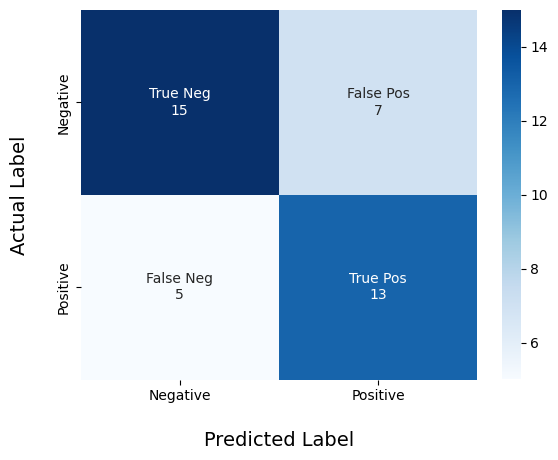

In [10]:
cm = confusion_matrix(y_test, prediction_RF)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels,fmt='', cmap='Blues')
ax.set_xlabel("Predicted Label", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_ylabel("Actual Label", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

In [11]:
# SVM
from sklearn import svm
svm_model = svm.SVC(C=0.1, gamma=1, kernel='linear', probability=True)

svm_model.fit(features,y_train)

start_SVM = time.perf_counter()
X_test_feature = VGG_model.predict(np.array(X_test))
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
prediction_SVM = svm_model.predict(X_test_features)
runtimes_SVM = time.perf_counter() - start_SVM

2/2 [==============================] - 6s 1s/step


In [12]:
# SVM
print ("Accuracy: {:.2f}%".format(metrics.accuracy_score(y_test, prediction_SVM)*100))
print("F1: {:.2f}".format(metrics.f1_score(y_test,prediction_SVM)))
print("AuC: {:.2f}".format(metrics.roc_auc_score(y_test, prediction_SVM)))
print("Precision : {:.2f}%".format(metrics.precision_score(y_test, prediction_SVM)*100))
print("Recall : {:.2f}%".format(metrics.recall_score(np.array(y_test), prediction_SVM)*100))
print("Run time: {:.2f}s ".format(runtimes_SVM))


Accuracy: 77.50%
F1: 0.79
AuC: 0.79
Precision : 68.00%
Recall : 94.44%
Run time: 5.77s 


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

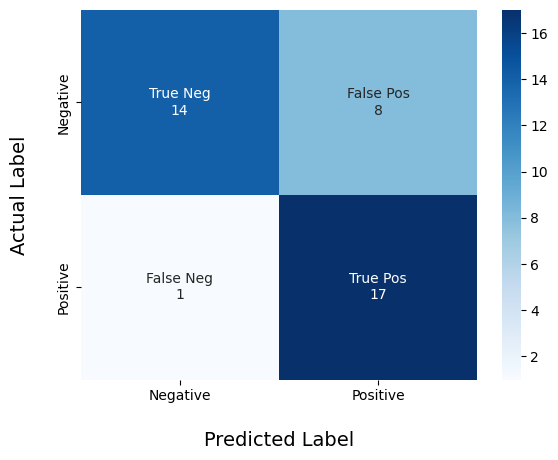

In [13]:
cm = confusion_matrix(y_test, prediction_SVM)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels,fmt='', cmap='Blues')
ax.set_xlabel("Predicted Label", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_ylabel("Actual Label", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

In [14]:
# After tuning SVM
svm_model = svm.SVC(C=0.1, 
                    gamma=1, 
                    kernel='linear',
                    tol=0.001,
                    max_iter=100, 
                    probability=True)

svm_model.fit(features,y_train)

start_SVM = time.perf_counter()
X_test_feature = VGG_model.predict(np.array(X_test))
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
prediction_SVM = svm_model.predict(X_test_features)
runtimes_SVM = time.perf_counter() - start_SVM

print ("Accuracy: {:.2f}%".format(metrics.accuracy_score(y_test, prediction_SVM)*100))
print("F1: {:.2f}".format(metrics.f1_score(y_test,prediction_SVM)))
print("AuC: {:.2f}".format(metrics.roc_auc_score(y_test, prediction_SVM)))
print("Precision : {:.2f}%".format(metrics.precision_score(y_test, prediction_SVM)*100))
print("Recall : {:.2f}%".format(metrics.recall_score(np.array(y_test), prediction_SVM)*100))
print("Run time: {:.2f}s ".format(runtimes_SVM))

c:\Users\ADMIN\anaconda3\envs\image-process\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


2/2 [==============================] - 6s 1s/step
Accuracy: 75.00%
F1: 0.77
AuC: 0.77
Precision : 65.38%
Recall : 94.44%
Run time: 5.84s 


In [15]:
# After tune RF
RF_model = RandomForestClassifier(n_estimators = 400, 
                                  min_samples_split=10,
                                  max_leaf_nodes=None,
                                  max_features='log2',
                                  max_depth=7,
                                  criterion='entropy',
                                  random_state = 42)

RF_model.fit(features, y_train)

start_RF = time.perf_counter()
X_test_feature = VGG_model.predict(np.array(X_test))
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
prediction_RF = RF_model.predict(X_test_features)
runtimes_RF = time.perf_counter() - start_RF

print ("Accuracy: {:.2f}%".format(metrics.accuracy_score(y_test, prediction_RF)*100))
print("F1: {:.2f}".format(metrics.f1_score(y_test,prediction_RF)))
print("AuC: {:.2f}".format(metrics.roc_auc_score(y_test, prediction_RF)))
print("Precision : {:.2f}%".format(metrics.precision_score(y_test, prediction_RF)*100))
print("Recall : {:.2f}%".format(metrics.recall_score(np.array(y_test), prediction_RF)*100))
print("Run time: {:.2f}s ".format(runtimes_RF))

2/2 [==============================] - 6s 1s/step
Accuracy: 67.50%
F1: 0.71
AuC: 0.69
Precision : 59.26%
Recall : 88.89%
Run time: 5.69s 
